In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import scipy as sp
from scipy.special import logsumexp
from sklearn.feature_extraction.text import TfidfVectorizer #ContentFiltering?
from sklearn.metrics.pairwise import cosine_similarity 
from surprise import Reader, Dataset, SVD, SVDpp, NMF, SlopeOne, CoClustering
from scipy.sparse import csr_matrix


from surprise import KNNBasic
from surprise import KNNWithMeans

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from surprise import accuracy
from time import time

from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
import heapq


# Libraries used during sorting procedures.
import heapq # <-- Efficient sorting of large lists
import operator # <-- Convienient item retrieval during iteration 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Import the train and test sets
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")

In [3]:
#Glance at train
train_df.head(), train_df.shape

(   userId  movieId  rating   timestamp
 0    5163    57669     4.0  1518349992
 1  106343        5     4.5  1206238739
 2  146790     5459     5.0  1076215539
 3  106362    32296     2.0  1423042565
 4    9041      366     3.0   833375837,
 (10000038, 4))

In [4]:
#Glance at test
test_df.head(), test_df.shape

(   userId  movieId
 0       1     2011
 1       1     4144
 2       1     5767
 3       1     6711
 4       1     7318,
 (5000019, 2))

In [5]:
#Drop timestamp
train_df=train_df.drop(["timestamp"],axis=1)

In [6]:
sampled_df=train_df.sample(n=9000000,random_state=2023)

In [7]:
# Bounds for predictions i.e. rating scale
bounds = Reader(rating_scale=(0.5, 5))

# A sample of 9million data points to be used for validating perfomance before large scale training using the full data set on the best perfoming model
validation = Dataset.load_from_df(train_df[["userId", "movieId", "rating"]].sample(frac=1, random_state=2023)[:9000000],bounds)

In [8]:
validation

C:\Users\F5588057\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\F5588057\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Average rating in dataset: 3.5332845555555554


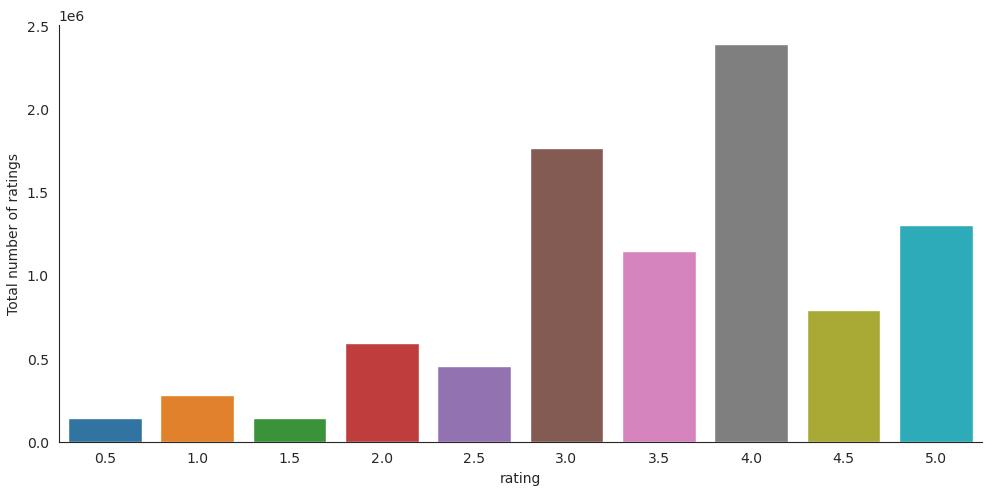

In [9]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=sampled_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(sampled_df["rating"])}')

In [10]:
# Build function to split data into 5 folds, fitting and testing the algorithm on each fold and then returing the RMSE score for each fold. 

def train_test(algo, data):                   
    
    kf = KFold(n_splits = 5)
    list_rmse = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)

        list_rmse.append(accuracy.rmse(predictions))  # prints RMSE score 
    return list_rmse



In [13]:
# Apply the SVD algorithm to build the recommender. "The Singular Value Decomposition (SVD) model
# is a kind of common collaborative filtering method "
svd = SVD()

rsme_svd = train_test(svd, validation)

RMSE: 0.8411
RMSE: 0.8415
RMSE: 0.8405
RMSE: 0.8405
RMSE: 0.8409


In [14]:
# Predict ratings from test dataset using SVD

# Separate user_id and movie_id from test dataframe dataset into lists
uid = np.array(test_df["userId"].values.tolist())
iid = np.array(test_df["movieId"].values.tolist())

# list of prediction of ratings of user and movie from test set 
predictions = [[svd.predict(uid[i], iid[i])] for i in range(len(iid))]

# format as required by kaggle 
Ids = [str(predictions[i][0].uid) +'_'+ str(predictions[i][0].iid) for i in range(len(predictions))]
ratings = [predictions[i][0].est for i in range(len(predictions))]

In [15]:
# Preparing submission file
Out3_df = pd.DataFrame(list(zip(Ids, ratings)), columns=['Id', 'rating'])

# Output
#Out3_df.to_csv('submission_sbu.csv', index=False)

# view submission file
Out3_df.head()

Id    rating
0  1_2011  3.391903
1  1_4144  4.046391
2  1_5767  3.559072
3  1_6711  3.542485
4  1_7318  2.937912

In [16]:
#Function to round predictions to rating scale
def myround(x, base=0.5):
    if x<0.5:
        result=0.5
    elif x>5:
        result = 5.0
    else:
        #result=base * round(x/base)
        result=round(x,1) #round to one decimal place
    return result

In [17]:
Out3_df['rating']=Out3_df['rating'].apply(myround)

In [18]:
# Output
Out3_df.to_csv('sbusiso_skosana_unsupervided_submission_11.csv', index=False)

# view submission file
Out3_df.head()

Id  rating
0  1_2011     3.4
1  1_4144     4.0
2  1_5767     3.6
3  1_6711     3.5
4  1_7318     2.9

In [17]:
Out3_df.head()

Id  rating
0  1_2011     3.4
1  1_4144     4.3
2  1_5767     3.6
3  1_6711     4.0
4  1_7318     3.0

In [ ]:
###          End of Notebook     